<a href="https://colab.research.google.com/github/AgastyaPatel/cits4012-group/blob/main/CITS4012_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("all")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data..

Sample rows:
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  

Missing values:
premise       0
hypothesis    0
label         0
dtype: int64

Removed 20 duplicate rows.

Tokenised example:
                                      premise_tokens  \
0  [pluto, rotates, once, on, it, axis, every, 63...   

                           

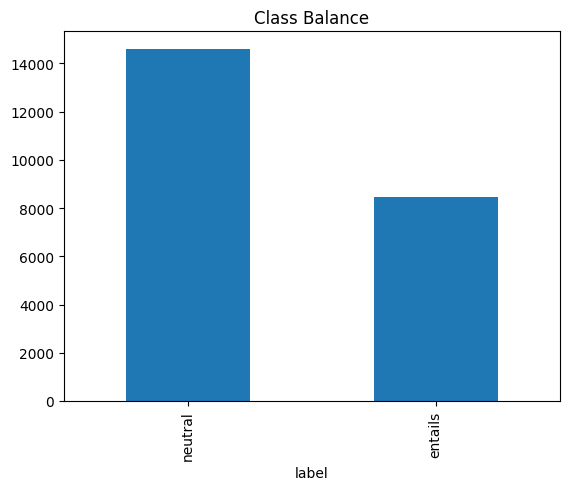

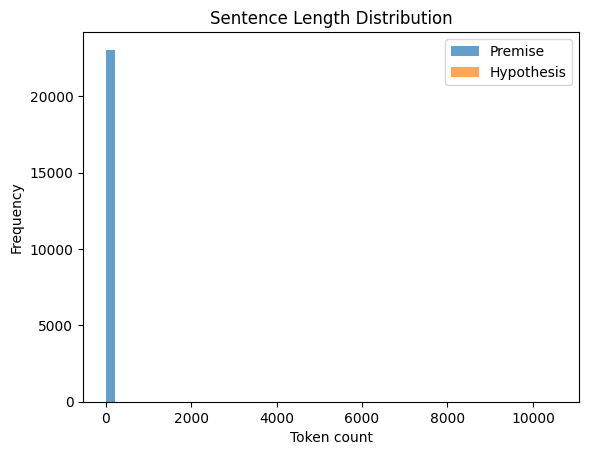

In [ ]:
# --- Step 1: Load dataset ---
with open("train_formatted.json", "r") as f:
    data = json.load(f)

# If it's a list of dicts with premise/hypothesis/label
df = pd.DataFrame(data)

print("Sample rows:")
print(df.head())

# --- Step 2: Handle missing data ---
print("\nMissing values:")
print(df.isnull().sum())
df = df.dropna()

# --- Step 3: Remove duplicates ---
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"\nRemoved {before - after} duplicate rows.")

# --- Step 4: Normalisation ---
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["premise"] = df["premise"].apply(normalize_text)
df["hypothesis"] = df["hypothesis"].apply(normalize_text)

# --- Step 5: Tokenisation + Lemmatization ---
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text, language='english') # Added language='english'
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

df["premise_tokens"] = df["premise"].apply(tokenize_and_lemmatize)
df["hypothesis_tokens"] = df["hypothesis"].apply(tokenize_and_lemmatize)

print("\nTokenised example:")
print(df[["premise_tokens", "hypothesis_tokens"]].head(1))

# --- Step 6: Class balance ---
label_counts = df["label"].value_counts()
print("\nClass distribution:")
print(label_counts)

label_counts.plot(kind="bar", title="Class Balance")
plt.show()

# --- Step 7: Sentence length distribution ---
premise_lens = df["premise_tokens"].apply(len)
hypothesis_lens = df["hypothesis_tokens"].apply(len)

plt.hist(premise_lens, bins=50, alpha=0.7, label="Premise")
plt.hist(hypothesis_lens, bins=50, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import math

# Transformer Architechture Inspiration
NLI tasks are generally done using just the encoder only transformer architechture model which can help us to do classification task like classifying the Hypothesis and premise as `entails` or `nuetral`

We can skip the decoder model to perform NLI task as we are not generating new stream of the text.

Our inspiration to begin with such encoder model was from the transformer model architechture based on the "Attention is all you need" paper

### NLI Task Setup

We can follow BERT STYLE for our input  
```
[CLS] Premise [SEP] Hypothesis [SEP]
↓
Encoder (BERT)
↓
[CLS] → Classification head → Entail / Contradict / Neutral
```

or T5-style (Encoder-decoder style)
```
Input: "mnli premise: <text1> hypothesis: <text2>"
Output: "entailment"
```

# Transformer Architecture
- Built on encoder - decoder model
- Built entirely on self attention + feed forward network layers (No Recurrence and convolution)

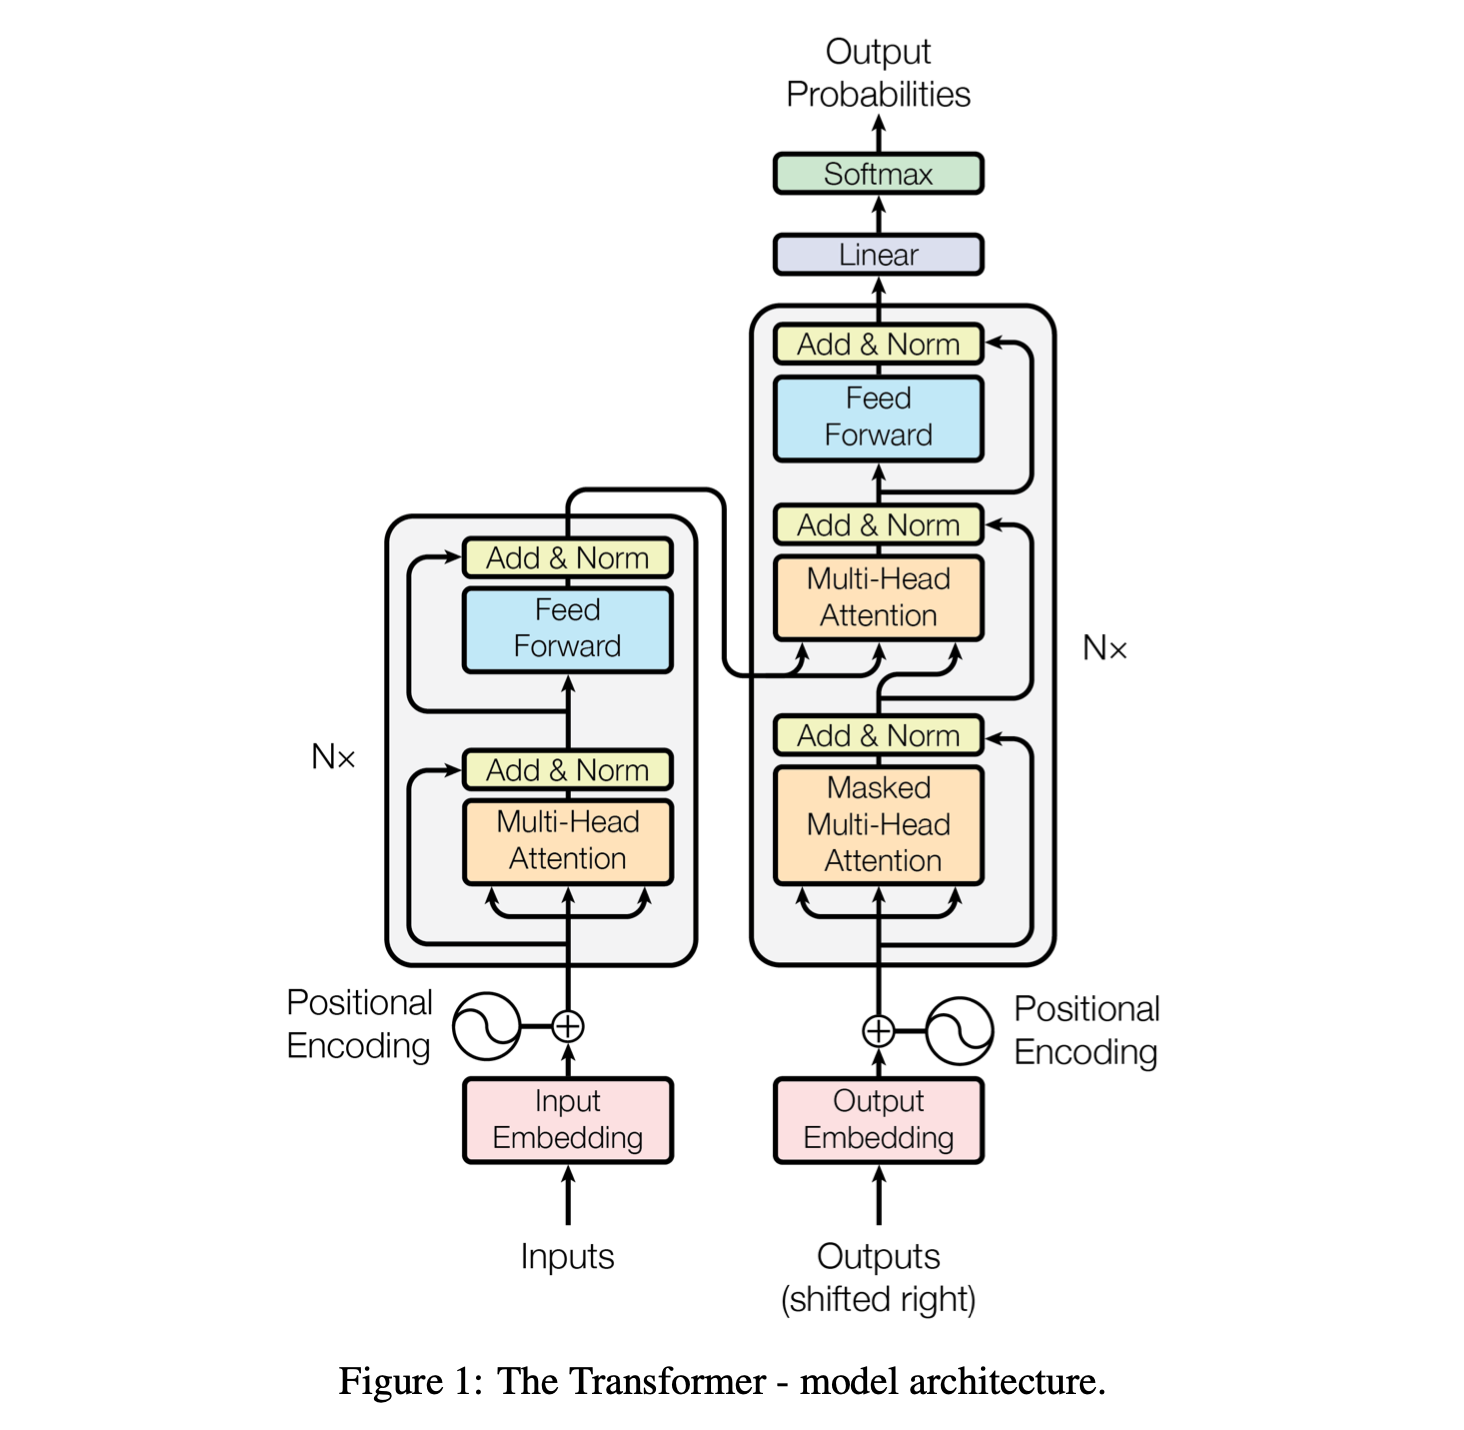

Understanding the transformer architechture
### Encoder (N times)
1. Input Embedding
2. Positional Encoding
3. MultiHead Attention + Add & Norm
4. Feed Forward + Add & Norm

### Decoder (N times)
1. Output Encoding
2. Positional Encoding
3. *Masked* MultiHead Attention + Add & Norm
4. Cross MultiHead Attention (Learnings from Encoder are embedded) + Add & Norm
5. Feed Forward + Add & Norm

### Output
1. Linear
2. Softmax

Since we are focusing on the encoder only transformer architechture we will be skipping out on the decoder part of the architechture


Encoder vs Decoder vs Full Transformer  
| Component| Core Idea | Used For | How it changes in NLI |
| ----- | ---- | ----- | ----- |
| Encoder only | Bidirectional attention sees full context | classification, sentence similarity | Best choice: can compare both texts directly |
| Decoder Only | Causal (left to right) | generation chat or reasoning | can be prompted for NLI but not trained specifically |
| Encoder-Decoder Only | Encoder reads input, decoder generates output | seq2seq (translation, summarisation) | Overhead unless you frame NLI as generation |  

Eg of different arch
- Encoder: BERT
- Decoder: GPT
- Encoder-decoder: T5/BERT

# Implementing components for Transformers

## Building Positional Encoding Module
Since transformer doesn't have idea about the previous sequence of knowledge and we need a way to embed the positional information about the data. So transformer paper suggest using of the Periodic functions which can help us out in maintaining the positional information while training.

Referrence: "Attention is all you need"

$$
\mathrm{PE}_{(pos,\,2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_\text{model}}}}\right)
$$

$$
\mathrm{PE}_{(pos,\,2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_\text{model}}}}\right)
$$

- pos: position of the token in the sequence (0, 1, 2, …)
- i: dimension index (0, 1, 2, …)
- d_{model}: the total embedding dimension (e.g., 512)
- 2i and 2i+1 split sine and cosine across even and odd indices

Basically we are using two formula based on the token's position. If the token is even or odd and then we use either cos or sin

In [ ]:
class Sinusoidal_Positional_Encoding(nn.Module):
    """
    d_model: Embedding dimension which is same as the input embedding dimension
    max_seq_len: the maximum length of the input sequence
    """
    def __init__(self, d_model: int, max_seq_len: int = 1000):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        # Positional Encoding Matrix
        pe = torch.zeros(max_seq_len, d_model)    # creating a zero matrix of shape of the maximum sequence length and the embedding dimension
        position = torch.arrange(0, max_seq_len, dtype=torch.float).unsqueeze(1)     # creating a position matrix of shape of the maximum sequence length
        div_term = torch.exp(torch.arrange(0, d_model, 2).float() * -(math.log(10000)/ d_model))
        pe[:, 0::2] = torch.sin(position * div_term)        # for even index
        pe[:, 1::2] = torch.cos(position * div_term)        # for odd index
        self.register_buffer("pe", pe)  # this is a buffer which becomes a parameter of the model without gradients

## Single Head Self Attention

### Masking
Masking is present in the multi head attention module present in decoder part of the transformer model.
This helps the model to avoid using the next tokens in the sequence for training 

In [ ]:
def casual_mask(T: int, device: torch.device)->torch.Tensor:
    """
    Returns a bool mask where True means *masked*
    """

    m = torch.triu(torch.ones(T, T, device=device), diagonal=1)
    return m.view(1,1,T,T)

### Attention
Referrence "Attention is all you need"

Here the attention head created is based on the scaled dot-product attention formula presented in the transformers paper  
**Scaled Dot-Product Attention Formula** : The scaled dot-product attention computes attention scores as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V
$$

where:
- \( Q \) = queries,
- \( K \) = keys,
- \( V \) = values,
- \( d_k \) = dimensionality of keys.


> Insert the Attention Image here

We are implementing the Scaled Dot Product (Left Diagram)

In [ ]:
class Single_Head_Self_Attention(nn.Module):
    """
    Single-Head Attention
    args:
        d_model: embedding dimension
        d_k: dimension of the key, value and 
        dropout: dropout rate
        trace_shapes: whether to trace the shapes of the tensors for debugging
    """
    def __init__(self, d_model: int, d_k: int, dropout: float = 0.0, causal: bool = True, trace_shapes: bool = False):
        super().__init__()
        self.d_k = d_k  # Store d_k as instance variable for use in forward
        self.q = nn.Linear(d_model, d_k, bias=False)
        self.k = nn.Linear(d_model, d_k, bias=False)
        self.v = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.causal = causal
        self.trace_shapes = trace_shapes
        
    def forward(self, x: torch.Tensor):  # (B, T, d_model)
        batch_size, seq_len, _ = x.shape
        q = self.q(x)    # (Batch_size, Seq_len, d_k)
        k = self.k(x)    # (Batch_size, Seq_len, d_k)
        v = self.v(x)    # (Batch_size, Seq_len, d_k)
        if self.trace_shapes:
            print(f"q: {tuple(q.shape)}")
            print(f"k: {tuple(k.shape)}")
            print(f"v: {tuple(v.shape)}")

        # Applying the scaled dot-product attention formula
        scale = 1.0 / math.sqrt(self.d_k)
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale   # (Batch_size, Seq_len, Seq_len)
        
        # Masking the upper triangle of the attention matrix
        # Why? To prevent the model from attending to future tokens during training
        if self.causal:
            mask = casual_mask(seq_len, device=x.device)
            attention = attention.masked_fill(mask.squeeze(1), float("-inf"))
        w = F.softmax(attention, dim=-1)
        w = self.dropout(w)
        out = torch.matmul(w, v)   # (Batch_size, Seq_len, d_k)
        if self.trace_shapes:
            print(f"Weights: {tuple(w.shape)} Out {out.shape}")
        return out, w
        

## Building multi head attention module

> Attach the attention image here

We are now implementing the Multiple Scaled Dot Product which are stacked (Right Diagram)

In [ ]:
class Multi_Head_Self_Attention(nn.Module):
    """
    Multi-Head Attention
    This represent one multi head self attention block

    args:
        d_model: embedding dimension
        n_heads: number of attention heads
        dropout: dropout rate
        trace_shapes: whether to trace the shapes of the tensors for debugging

    note:
        d_k (d_head here) ie, dimension of the key, value and query is same as d_model / n_heads
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.0, causal: bool = True, trace_shapes: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.causal = causal
        self.trace_shapes = trace_shapes
        
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)      # we need to project the input to 3 times the dimension of the input so that we can split it into query, key and value
        self.proj = nn.Linear(d_model, d_model, bias=False)         # after the attention computation, we need to project the output back to the original dimension


    def forward(self, x: torch.Tensor):
        batch_size, seq_len, C = x.shape   # c is the embedding dimension
        qkv = self.qkv(x)
        qkv = qkv.view(batch_size, seq_len, 3, self.n_heads, self.d_head)
        q, k, v = qkv.unbind(dim=2)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        if self.trace_shapes:
            print(f"q: {tuple(q.shape)}")
            print(f"k: {tuple(k.shape)}")
            print(f"v: {tuple(v.shape)}")

        scale = 1.0 / math.sqrt(self.d_head)
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale

        # mask out the upper triangle of the attention matrix
        if self.causal:
            mask = casual_mask(seq_len, device=x.device)
            attention = attention.masked_fill(mask, float("-inf"))
        
        w = F.softmax(attention, dim=-1)
        w = self.dropout(w)
        ctx = torch.matmul(w, v)
        if self.trace_shapes:
            print(f"ctx: {tuple(ctx.shape)}")
        ctx = ctx.transpose(1, 2)
        # we need to make sure that the context is contiguous
        # because the view operation is not guaranteed to be contiguous
        # if it is not contiguous, the view operation will throw an error
        # contiguous means that the memory is in a contiguous block
        ctx = ctx.contiguous().view(batch_size, seq_len, C)
        out = self.proj(ctx)
        return out
        

# Building Cross Attention

## Cross-Attention for Decoder

Cross-attention is a key component of the transformer decoder. Unlike self-attention where queries, keys, and values all come from the same sequence, in cross-attention:
- **Queries (Q)**: Come from the decoder (target sequence)
- **Keys (K) and Values (V)**: Come from the encoder (source sequence)

This allows the decoder to attend to the encoder's representations while generating the target sequence.


In [ ]:
class CrossAttention(nn.Module):
    """
    Cross-Attention mechanism for transformer decoder.
    
    In cross-attention:
    - Queries come from decoder (target sequence)
    - Keys and Values come from encoder (source sequence)
    
    Args:
        d_model: embedding dimension
        n_heads: number of attention heads
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.0, trace_shapes: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.trace_shapes = trace_shapes
        
        # Separate projections for queries (from decoder) and keys/values (from encoder)
        self.q_proj = nn.Linear(d_model, d_model, bias=False)  # Queries from decoder
        self.kv_proj = nn.Linear(d_model, 2 * d_model, bias=False)  # Keys and Values from encoder
        self.out_proj = nn.Linear(d_model, d_model, bias=False)  # Output projection
        
    def forward(self, decoder_hidden: torch.Tensor, encoder_output: torch.Tensor, 
                src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            decoder_hidden: decoder representations (B, tgt_len, d_model)
            encoder_output: encoder representations (B, src_len, d_model)  
            src_mask: source padding mask (B, src_len) - True for padding positions
        Returns:
            output: cross-attended representations (B, tgt_len, d_model)
        """
        B, tgt_len, _ = decoder_hidden.shape
        B, src_len, _ = encoder_output.shape
        
        # Generate queries from decoder hidden states
        q = self.q_proj(decoder_hidden)  # (B, tgt_len, d_model)
        
        # Generate keys and values from encoder output
        kv = self.kv_proj(encoder_output)  # (B, src_len, 2 * d_model)
        
        # Reshape for multi-head attention
        q = q.view(B, tgt_len, self.n_heads, self.d_head).transpose(1, 2)  # (B, n_heads, tgt_len, d_head)
        kv = kv.view(B, src_len, 2, self.n_heads, self.d_head)
        k, v = kv.unbind(dim=2)  # Each: (B, src_len, n_heads, d_head)
        k = k.transpose(1, 2)  # (B, n_heads, src_len, d_head)
        v = v.transpose(1, 2)  # (B, n_heads, src_len, d_head)
        
        if self.trace_shapes:
            print(f"Cross-attention - q: {tuple(q.shape)}, k: {tuple(k.shape)}, v: {tuple(v.shape)}")
            
        # Scaled dot-product attention
        scale = 1.0 / math.sqrt(self.d_head)
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, n_heads, tgt_len, src_len)
        
        # Apply source mask if provided (mask out padding tokens in source)
        if src_mask is not None:
            # Expand mask for multi-head attention: (B, 1, 1, src_len)
            src_mask = src_mask.unsqueeze(1).unsqueeze(2)
            attention_scores = attention_scores.masked_fill(src_mask, float('-inf'))
            
        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, v)  # (B, n_heads, tgt_len, d_head)
        
        if self.trace_shapes:
            print(f"Cross-attention context: {tuple(context.shape)}")
            
        # Concatenate heads and project
        context = context.transpose(1, 2).contiguous().view(B, tgt_len, self.d_model)
        output = self.out_proj(context)
        
        return output


## Feedforward

In [ ]:
## Building simple feed forward network with GELU activation
class FeedForward(nn.Module):
    """
    Position-wise Feed Forward Network
    
    Args:
        d_model: input/output dimension
        d_hd : hidden dimension
        dropout: dropout rate
    """

    def __init__(self, d_model: int, d_hd: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_hd)
        self.linear2 = nn.Linear(d_hd, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """
        x : (Batch_size, Seq_len, d_model)
        returns : (Batch_size, Seq_len, d_model)
        """
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

## Building Layer normalization
mean of all features
$$
\mu = \frac{1}{D} \sum_{i=1}^{D} x_i, \quad
$$

variabce of all features
$$
\sigma^2 = \frac{1}{D} \sum_{i=1}^{D} (x_i - \mu)^2
$$

$$
\text{LayerNorm}(x_i) = \gamma \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

In [ ]:
class LayerNorm(nn.Module):
    """
    Layer Normalization

    Args:
        d_model : dimension to normalize over
        eps : using small value to avoid division by zero
        bias : boolean to include bias or not
    """

    def __init__(self, d_model: int, eps: float = 1e-5, bias: bool = True):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model)) if bias else None

    def forward(self, x: torch.Tensor):
        """
        x : (Batch_size, Seq_len, d_model)
        returns : (Batch_size, Seq_len, d_model)
        """
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized = (x - mean) / torch.sqrt(var + self.eps)
        normalized = normalized * self.weight
        if self.bias is not None:
            normalized = normalized + self.bias
        return normalized
        


we can use nn.LayerNormalization from pytorch to implement the layernormalization directly

In [ ]:
# LayerNorm = nn.LayerNorm(d_model, eps=1e-5, elementwise_affine=True) 
# elementwise_affine = True means that the layer normalization will have learnable parameters ie, weights and biases
# if we set it to False, the layer normalization will not have any learnable parameters and it will be a simple layer normalization

In [ ]:
class Residual_Connection(nn.Module):
    """
    Residual connection with layer normalization.
    It supports both pre normalization and post normalization
    """
    def __init__(self, d_model: int, dropout: float = 0.1, bias: bool = True, pre_norm: bool = True):
        super().__init__()
        self.norm = nn.LayerNorm(d_model, eps=1e-5, elementwise_affine=bias)
        self.dropout = nn.Dropout(dropout)
        self.pre_norm = pre_norm
        
    def forward(self, x, sublayer) -> torch.Tensor:
        """
        Apply residual connection to any sublayer with the same size

        Args:
            x: input tensor (batch_size, seq_len, d_model)
            sublayer: function that takes x and returns tensor of same shape
        Returns:
            output: (batch_size, seq_len, d_model)
        """
        if self.pre_norm:
            return x + self.dropout(sublayer(self.norm(x)))
        else:
            return self.norm(x + self.dropout(sublayer(x)))
            

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    This is a convenience wrapper that combines residual connection and layer norm.
    """
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer) -> torch.Tensor:
        return x + self.dropout(sublayer(self.norm(x)))


# Encoder Flow
```
Input: x (batch_size, seq_len, d_model)
    ↓
1. Attention + Residual:
   x = x + dropout(self_attention(layer_norm(x)))
    ↓  
2. Feed Forward + Residual:
   x = x + dropout(feed_forward(layer_norm(x)))
    ↓
Output: x (batch_size, seq_len, d_model)
```

## Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """
    A single transformer encoder block

    Args:
        d_model: model dimension
        n_heads: number of attention heads
        d_ff: feed forward hidden dimension
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, trace_shapes: bool = False):
        super().__init__()
        self.d_model = d_model
        self.trace_shapes = trace_shapes
        
        self.self_attention = Multi_Head_Self_Attention(
            d_model=d_model,
            n_heads=n_heads,
            dropout=dropout,
            trace_shapes=trace_shapes,
            causal=False
        )
        
        self.feed_forward = FeedForward(
            d_model = d_model,
            d_ff = d_ff,
            dropout = dropout
        )

        self.sublayer1 = SublayerConnection(d_model, dropout)
        self.sublayer2 = SublayerConnection(d_model, dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the encoder block

        Args:
            x: input tensor (batch_size, seq_len, d_model)
            mask: attention_mask (batch_size, seq_len) - True for positions to mask

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        if self.trace_shapes:
            print(f"EncoderBlock input: {tuple(x.shape)}")

        # Self-attention with residual connection
        x = self.sublayer1(x, lambda x: self.self_attention(x))
        if self.trace_shapes:
            print(f"After self-attention: {tuple(x.shape)}")

        # Feed forward with residual connection
        x = self.sublayer2(x, lambda x: self.feed_forward(x))

        if self.trace_shapes:
            print(f"EncoderBlock output: {tuple(x.shape)}")
        
        return x

## Stacked Encoder Block

In [ ]:
class StackedEncoderBlocks(nn.Module):
    """
    Stack of N transformer encoder blocks.
    
    Args:
        n_layers: number of encoder blocks
        d_model: model dimension
        n_heads: number of attention heads
        d_ff: feed forward hidden dimension
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """
    
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, trace_shapes: bool = False):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(
                d_model=d_model,
                n_heads=n_heads,
                d_ff=d_ff,
                dropout=dropout,
                trace_shapes=trace_shapes
            )
            for _ in range(n_layers)
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the stacked encoder blocks
        mask: attention mask (batch_size, seq_len) - True for positions to mask

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, mask)
        return x

## Ablation study

### Based on the positional Encoding

In [ ]:
# For ablation study, we can use the learned positional encoding as well
class Learned_Positional_Encoding(nn.Module):
    """
    d_model: Embedding dimension
    max_seq_len: the maximum length of the input sequence
    """
    def __init__(self, d_model: int, max_seq_len: int = 1000):
        super().__init__()
        self.embeddding = nn.Embedding(max_seq_len, d_model)

    def forward(self, x: torch.Tensor)->torch.Tensor:
        """
        x(input): (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.size()
        pos = torch.arrange(seq_len, device=x.device).unsqueeze(0)
        pos_emb = self.embeddding(pos)
        return x + pos_emb.unsqueeze(0)

### Based on masking

In [ ]:
# for ablation study, we can use the no_mask as well
def no_mask(T: int, device: torch.device)->torch.Tensor:
    return torch.zeros(1, 1, T, T, dtype=torch.bool, device=device)

no mask should cause data leakage but can be used as our baseline

In [ ]:
def random_mask(T: int, device: torch.device, mask_prob: float = 0.15)->torch.Tensor:
    mask = torch.rand(1,1,T,T, device=device) < mask_prob
    return mask

Testing how our model handles random occlusion. Can be useful when exploring the robustness or masked language modelling
Can simulate missing information

## Based on adding decoder into the model 
trying to get the NLI Task executed with encoder-decoder architechture